In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset
train = pd.read_csv(r'C:\Users\Ahmed\Desktop\house-prices-advanced-regression-techniques\train.csv')
test = pd.read_csv(r'C:\Users\Ahmed\Desktop\house-prices-advanced-regression-techniques\test.csv')

In [3]:
# Drop ID column and save for later
ntrain = train.shape[0]
ntest = test.shape[0]

tainID = train['Id']
train.drop('Id', axis = 1, inplace = True)

testID = test['Id']
test.drop('Id', axis = 1, inplace = True)

print('The train data shape is {}'.format(train.shape))
print('The test data shape is {}'.format(test.shape))

The train data shape is (1460, 80)
The test data shape is (1459, 79)


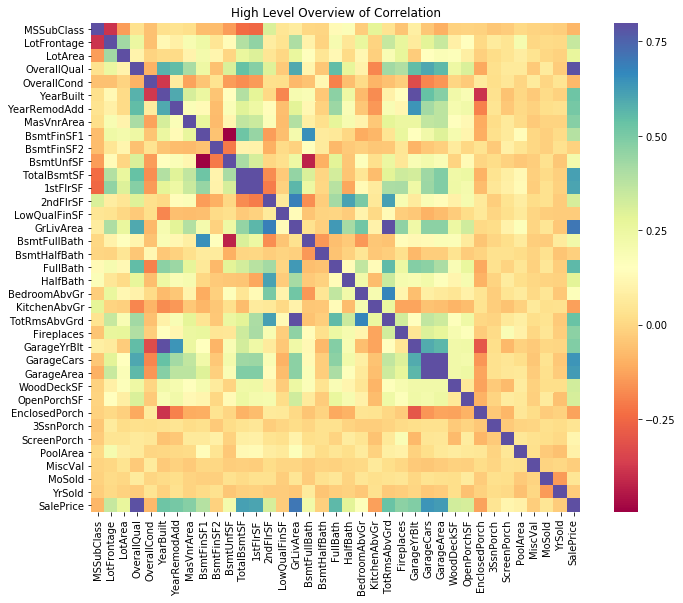

In [4]:
# High level overview of correlated features
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
plt.title('High Level Overview of Correlation')
sns.heatmap(corrmat, vmax=.8, square=True, cmap = 'Spectral')

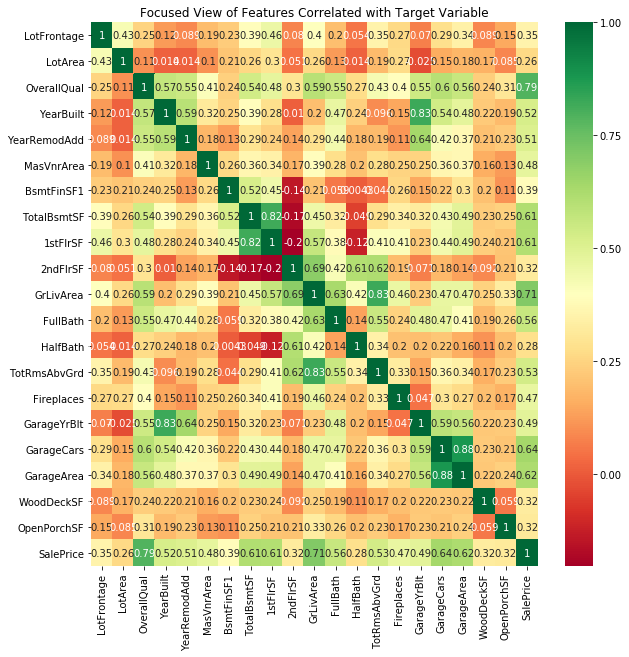

In [5]:
# Focused view of features correlated with target variable
corrmat_focused = corrmat.index[(corrmat['SalePrice'])>0.25]
plt.figure(figsize = (10, 10))
plt.title('Focused View of Features Correlated with Target Variable')
sns.heatmap(train[corrmat_focused].corr(),cmap = 'RdYlGn', annot = True)

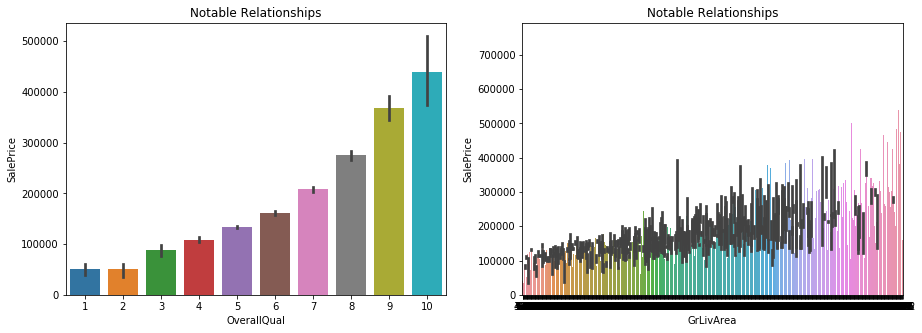

In [6]:
# Overall Quality and General Living Area are the most highly correlated with the Sale Price
# Visualzing the distribution and the probability after transforming the target variable
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Notable Relationships')
sns.barplot(train.OverallQual, train.SalePrice)
plt.subplot(1,2,2)
plt.title('Notable Relationships')
sns.barplot(train.GrLivArea, train.SalePrice)

In [7]:
# Inspect target variable
train['SalePrice'].describe().round(3)

count      1460.000
mean     180921.196
std       79442.503
min       34900.000
25%      129975.000
50%      163000.000
75%      214000.000
max      755000.000
Name: SalePrice, dtype: float64

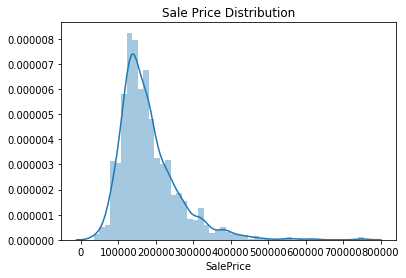

In [8]:
# Inspect target variable
plt.title('Sale Price Distribution')
sns.distplot(train['SalePrice'])

In [9]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())
print('The target variable {0} appears to be right skewed with an outlier of ${1}'.format('SalePrice', train['SalePrice'].max()))

Skewness: 1.882876
Kurtosis: 6.536282
The target variable SalePrice appears to be right skewed with an outlier of $755000


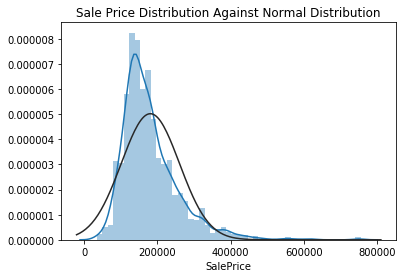

In [10]:
# Normalize the target variable
plt.title('Sale Price Distribution Against Normal Distribution')
sns.distplot(train['SalePrice'], fit = norm)

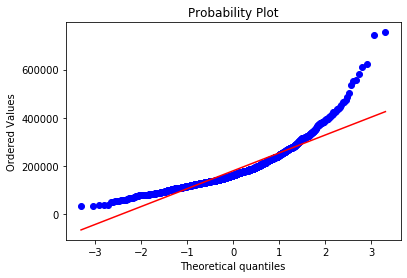

In [11]:
# Normalize the target variable
res = stats.probplot(train['SalePrice'], plot = plt)

In [12]:
print("We will normalize the target variable {0}, using a {1}".format('SalePrice', 'Log Transformation'))

We will normalize the target variable SalePrice, using a Log Transformation


In [13]:
# Normalize the target variable
train['SalePrice'] = np.log(train['SalePrice'])

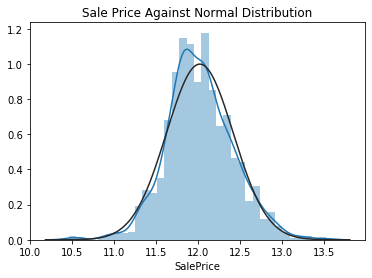

In [14]:
plt.title('Sale Price Against Normal Distribution')
sns.distplot(train['SalePrice'], fit = norm)

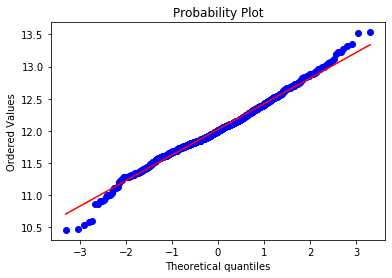

In [15]:
res = stats.probplot(train['SalePrice'], plot = plt)

In [16]:
# Combine Train and Test data for cleaning 
SalePrice = train['SalePrice']
all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
all_data.shape

(2919, 79)

In [17]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [18]:
# Treat missing data
null_count = all_data.isnull().sum()
null_percent = (all_data.isnull().sum())/(all_data.isnull().count())*100
null_percent = null_percent.round(4)
null_type = all_data.dtypes
missing_data = pd.concat([null_count, null_percent, null_type], axis = 1, keys = ['Total Null', '% of Total', 'Data Type'])
missing_data = missing_data.sort_values(by = '% of Total', ascending = False).round()
missing_data.head(35)

,Total Null,% of Total,Data Type
PoolQC,2909,100.0,object
MiscFeature,2814,96.0,object
Alley,2721,93.0,object
Fence,2348,80.0,object
FireplaceQu,1420,49.0,object
LotFrontage,486,17.0,float64
GarageYrBlt,159,5.0,float64
GarageQual,159,5.0,object
GarageFinish,159,5.0,object
GarageCond,159,5.0,object


In [19]:
# Treat missing data
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
all_data['Alley'] = all_data['Alley'].fillna('None')
all_data['Fence'] = all_data['Fence'].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)
all_data['GarageQual'] = all_data['GarageQual'].fillna('None')
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('None')
all_data['GarageCond'] = all_data['GarageCond'].fillna('None')
all_data['GarageType'] = all_data['GarageType'].fillna('None')
all_data['BsmtCond'] = all_data['BsmtCond'].fillna('None')
all_data['BsmtExposure'] = all_data['BsmtExposure'].fillna('None')
all_data['BsmtQual'] = all_data['BsmtQual'].fillna('None')
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('None')
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].fillna('None')
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].fillna('None')
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna('RL')
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data = all_data.drop(['Utilities'], axis=1)
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('VinylSd')
all_data['GarageArea'] = all_data['GarageArea'].fillna(0)
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('VinylSd')
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(0)
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(0)
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('VinylSd')
all_data['GarageCars'] = all_data['GarageCars'].fillna(0)
all_data['SaleType'] = all_data['SaleType'].fillna('WD')
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)

In [20]:
null_count = all_data.isnull().sum()
null_percent = (all_data.isnull().sum())/(all_data.isnull().count())*100
null_percent = null_percent.round(4)
null_type = all_data.dtypes
missing_data = pd.concat([null_count, null_percent, null_type], axis = 1, keys = ['Total Null', '% of Total', 'Data Type'])
missing_data = missing_data.sort_values(by = '% of Total', ascending = False).round()
missing_data.head(5)

,Total Null,% of Total,Data Type
1stFlrSF,0,0.0,int64
LotFrontage,0,0.0,float64
MiscFeature,0,0.0,object
MasVnrType,0,0.0,object
MasVnrArea,0,0.0,float64


In [21]:
# Feature Engineering to convert data types where appropriate
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].apply(int)

In [22]:
# Feature Engineering to add a key variable
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [23]:
# Label ordinal categorical variables
cols = ('BsmtCond', 'BsmtExposure', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageFinish', 
       'GarageQual', 'HeatingQC', 'KitchenQual', 'LandSlope', 'LotShape', 'PoolQC', 'BsmtFinType1', 'BsmtFinType2', 
        'Functional', 'Fence', 'PavedDrive', 'Central Air', 'OverallCond')

In [24]:
# Correct highly skewed variables
numerical_features = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_numerical_features = all_data[numerical_features].apply(lambda x: skew(x)).sort_values(ascending = False)
skewness = pd.DataFrame({'Skew' : skewed_numerical_features})
skewness.head(10)

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694
BsmtHalfBath,3.931594


In [25]:
# Correct highly skewed variables
skewness = skewness[abs(skewness) > 0.75]
print('We will use the Box Cox transformation to correct the {} highly skewed variables'.format(skewness.shape[0]))

We will use the Box Cox transformation to correct the 36 highly skewed variables


In [26]:
# Correct highly skewed variables
from scipy.special import boxcox1p
skewness_index = skewness.index
lam = 0.15
for feature in skewness_index:
    all_data[feature] = boxcox1p(all_data[feature], lam)

In [27]:
# Get dummy variables for all nominal categorical variables
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 316)


In [28]:
# Split train and test data once again
train = all_data[:ntrain]
test = all_data[ntrain:]

In [29]:
print('The train data shape is {}'.format(train.shape))
print('The test data shape is {}'.format(test.shape))

The train data shape is (1460, 316)
The test data shape is (1459, 316)


In [30]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train, SalePrice, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1022, 316) (438, 316) (1022,) (438,)


In [31]:
# Linear Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
lm_train = regressor.predict(X_train)
lm_test = regressor.predict(X_test)
print('The performance on the train set is: %.2f'% r2_score(y_train, lm_train),
     'The performance on the test set is: %.2f'% r2_score(y_test, lm_test), sep = '\n')

The performance on the train set is: 0.95
The performance on the test set is: 0.65


In [36]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 5000, max_depth = 4, n_jobs = -1)
rf.fit(X_train, y_train)
rf_train = rf.predict(X_train)
rf_test = rf.predict(X_test)
print('Performance on train set: %.2f' % r2_score(y_train, rf_train),
      'Performance on test set: %.2f' % r2_score(y_test, rf_test),sep="\n")

Performance on train set: 0.86
Performance on test set: 0.85


In [33]:
# Make final prediction
rf_pred = rf.predict(test)
submission_dataframe = pd.DataFrame()
submission_dataframe['Id'] = testID
submission_dataframe['LogSalePrice'] = rf_pred
submission_dataframe['SalePrice'] = np.exp(submission_dataframe['LogSalePrice'])
submission_dataframe.drop(['LogSalePrice'], axis = 1, inplace = True)

In [34]:
submission_dataframe.to_csv('HousePrice.csv', index = False)